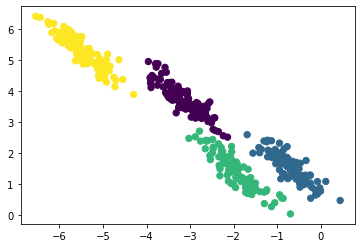

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
rng = np.random.RandomState(13) # Random number Generator with fixed state
X_stretched = np.dot(X, rng.randn(2, 2))
X = X_stretched
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis')

In [2]:
random.sample(list(X), 4)

[array([-0.49076126,  1.19268235]),
 array([-1.95833475,  1.40482913]),
 array([-2.59491901,  2.39484389]),
 array([-6.4439832 ,  6.37007345])]

### Implement the class for the GMM.  
#### Try to implement at least 3 methods for init_centers, including the method k-means. 
##### You can also suggest and implement other methods.

In [3]:
from sklearn.metrics import silhouette_score

class GMM:
    
    def __init__(self, k, method='k-means', max_iter=100, tol=1e-6):
        self.k = k 
        self.method = method
        self.max_iter = max_iter
        self.weight = [1/self.k for _ in range(self.k)]
        self.tol = tol
        
    
    def init_centers(self, X):
        
        if self.method == 'random_mean_std':
            # generate K random means and stds
            mean_arr, cov_arr, pi_arr = random.sample(list(X), self.k),\
                                        [np.cov(x.T) for x in np.array_split(np.random.rand(*X.shape), self.k)],\
                                        [1/self.k for _ in range(self.k)] 
        
        elif self.method == 'random_mean':
            # generate K random means
            mean_arr, cov_arr, pi_arr = random.sample(list(X), self.k),\
                                        [np.cov(i.T) for i in np.array_split(X, self.k)],\
                                        [1/self.k for _ in range(self.k)] 
                    
            print(mean_arr)
        elif self.method == 'k-means':
            
            # generate initial points by KMeans algo
            model = KMeans(self.k, random_state=777)
            model.fit(X)
            pred = model.predict(X)
            labels = model.labels_
            mean_arr, cov_arr, pi_arr = [X[np.where(labels == i)[0]].mean(axis=0) for i in np.unique(labels)],\
                                        [np.cov(X[np.where(labels == i)[0]].T) for i in np.unique(labels)],\
                                        [1/self.k for _ in range(self.k)] 
            
        elif self.method == 'random_divide':
            
            # Devide data into k non-repeating samples
            
            mean_arr, cov_arr, pi_arr = [x.mean(axis=0) for x in np.array_split(X, self.k)],\
                                        [np.cov(x.T) for x in np.array_split(X, self.k)],\
                                        [1/self.k for _ in range(self.k)] 
            
        self.mean, self.cov, self.pi = np.array(mean_arr), np.array(cov_arr), np.array(pi_arr)
                            
    
    def fit(self, X):
        self.init_centers(X)
        for _ in range(self.max_iter):
            self.expectation(X)
            self.maximization(X)
    
    def pdf(self, X, mean, cov):
        return mvn(mean, cov).pdf(X)
    
    def likelihood(self, X):
        tmp = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            tmp[:, i] = self.pdf(X, self.mean[i], self.cov[i])
        return tmp
            
    def expectation(self, X):
        l = self.likelihood(X)
        w = self.weight*l
        self.weight = w
        self.pi = w/w.mean(axis=1).reshape(-1, 1)

    def maximization(self, X):
        weights = self.pi.sum(axis=0)
        for i in range(self.k):
            w = self.pi[:, [i]]
            self.mean[i] = (w * X).sum(axis=0) / w.sum()
            self.cov[i] = (X - self.mean[i]).T.dot((X - self.mean[i]) * w) / weights[i]
        
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        l = self.likelihood(X)
        w = self.weight*l
        return w
    
    @property
    def mean_arr(self):
        return self.mean
    
    def score(self, X, labels):
        return silhouette_score(X, labels)

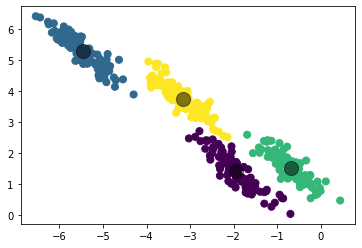

In [4]:
gmm = GMM(k=4, method='k-means')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [5]:
gmm.score(X, pred)

0.5501162205977507

[array([-2.82320262,  3.35838724]), array([-5.60254385,  5.53854788]), array([-3.73846534,  4.87602497]), array([-0.24556892,  1.2794214 ])]


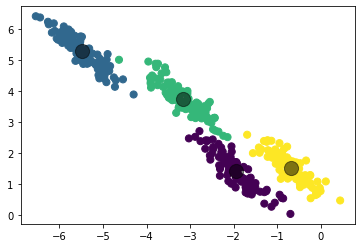

In [6]:
gmm = GMM(k=4, method='random_mean')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)
plt.show()

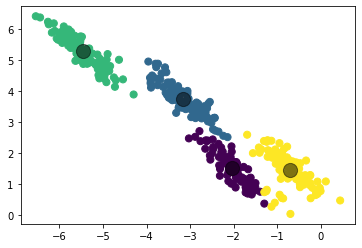

In [7]:
gmm = GMM(k=4, method='random_mean_std')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)
plt.show()

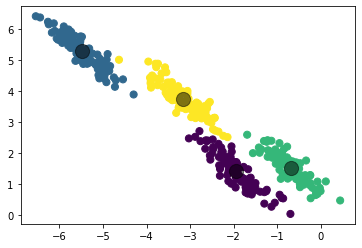

In [8]:
gmm = GMM(k=4, method='random_divide')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)
plt.show()

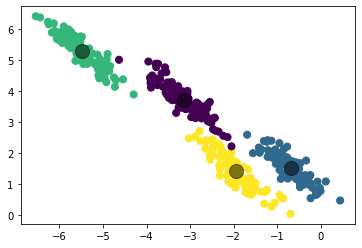

In [9]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4)
gm.fit(X)
prediction = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='black', s=200, alpha=0.5)
plt.show()